# Inference using Borzoi

In this tutorial, we learn how to download a pre-trained model from the gReLU model zoo, use it for inference, visualize the results and interpret the model.

In [1]:
import numpy as np
import pandas as pd
import torch

## Load the pre-trained Borzoi model from the model zoo

The `grelu.resources` module contains functions to access saved models and datasets associated with gReLU. `grelu.resources.load_model` is the function to load a saved model from the model zoo. We will load the Borzoi model (https://www.biorxiv.org/content/10.1101/2023.08.30.555582v1) trained to predict thousands of human genomic tracks from sequence.

In [2]:
import grelu.resources
model = grelu.resources.load_model(
    project="borzoi",
    model_name="human_fold0" # You can change the fold number or change human to mouse
)

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Currently logged in as: lal-avantika (grelu). Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact human_fold0:latest, 711.00MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0


## View the model's metadata

`model.data_params` is a dictionary containing metadata about the data used to train the model. Let's look at what information is stored:

In [3]:
model.data_params.keys()

dict_keys(['tasks', 'train_seq_len', 'train_label_len', 'train_genome', 'train_bin_size'])

Let's print some of these metadata fields:

In [4]:
for key in model.data_params.keys():
    if key !="tasks":
        print(key, model.data_params[key])

train_seq_len 524288
train_label_len 16384
train_genome hg38
train_bin_size 32


This tells us that the model was trained on sequences of length 524288 bp from the hg38 genome, and predicts labels for 16384 bins of 32 bp width.
You'll notice we left out `tasks`. This is a large dictionary containing metadata about the output tracks that the model predicts. We can collect these into a dataframe called `tasks`:

In [5]:
tasks = pd.DataFrame(model.data_params['tasks'])
tasks.head(3)

,name,file,clip,clip_soft,scale,sum_stat,strand_pair,description,assay,sample
0,CNhs10608+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.0,sum,1,CAGE:Clontech Human Universal Reference Total ...,CAGE,"Clontech Human Universal Reference Total RNA, ..."
1,CNhs10608-,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.0,sum,0,CAGE:Clontech Human Universal Reference Total ...,CAGE,"Clontech Human Universal Reference Total RNA, ..."
2,CNhs10610+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.0,sum,3,CAGE:SABiosciences XpressRef Human Universal T...,CAGE,SABiosciences XpressRef Human Universal Total ...


## Make inference intervals

We will now use the model to make predictions on a specific genomic interval from chromosome 1. Since the model was trained on sequences of length 524288 bp, our input interval will be of the same length.

In [6]:
input_len = model.data_params["train_seq_len"]
chrom = "chr1"
input_start = 69993520
input_end = input_start + input_len

We format the interval(s) that we want to make predictions on as a dataframe containing columns "chrom", "start" and "end". A "strand" column can be supplied optionally.

In [7]:
input_intervals = pd.DataFrame({
    'chrom':[chrom], 'start':[input_start], 'end':[input_end], "strand":["+"],
})

input_intervals

,chrom,start,end,strand
0,chr1,69993520,70517808,+


## Extract the sequence

`grelu.sequence.format` contains functions to convert DNA sequences from one format to another. Here, we use it to convert the genomic interval into a string:

In [8]:
import grelu.sequence.format
input_seqs = grelu.sequence.format.convert_input_type(
    input_intervals,
    output_type="strings",
    genome="hg38"
)
input_seq = input_seqs[0]

len(input_seq)

524288

This is a very long sequence - let's just look at the beginning.

In [9]:
input_seq[:10]

'ACTGTGCACC'

## Run inference

We can use the model to make a prediction on a single sequence with a very simple command. If we want to make predictions on many sequences, or average the predictions over different versions of the sequence, we should use gReLU's pytorch dataset classes. We'll see how to do that later.

In [10]:
%%time
preds = model.predict_on_seqs(input_seqs, device=1)
preds.shape

CPU times: user 8.73 s, sys: 617 ms, total: 9.35 s
Wall time: 1.4 s


(1, 7611, 6144)

Note the shape of `preds`: it's in the format `Batch, Tasks, Length`. So we have 1 sequence, 7611 tasks, and 6144 bins along the length axis.

## Get output interval coordinates

We know that the input was a 524288 bp region from chr1:69993520-70517808. But Borzoi is not making predictions for the entire region; it's cropping some positions from the sides. We can find out the region for which we are actually making predictions using the `input_intervals_to_output_intervals` method.

In [11]:
output_intervals = model.input_intervals_to_output_intervals(input_intervals)
output_intervals

,chrom,start,end,strand
0,chr1,70157360,70353968,+


In [12]:
output_start = output_intervals.start[0]
output_end = output_intervals.end[0]
output_len = output_end - output_start
print(output_len)

196608


We see that our predictions encompass the central 196608 bp of the input 524288 bp.

## Plot predictions

Now, we visualize the Borzoi predictions over the output region.

In [13]:
import grelu.visualize
%matplotlib inline

As an example, we will visualize the first 4 output tracks.

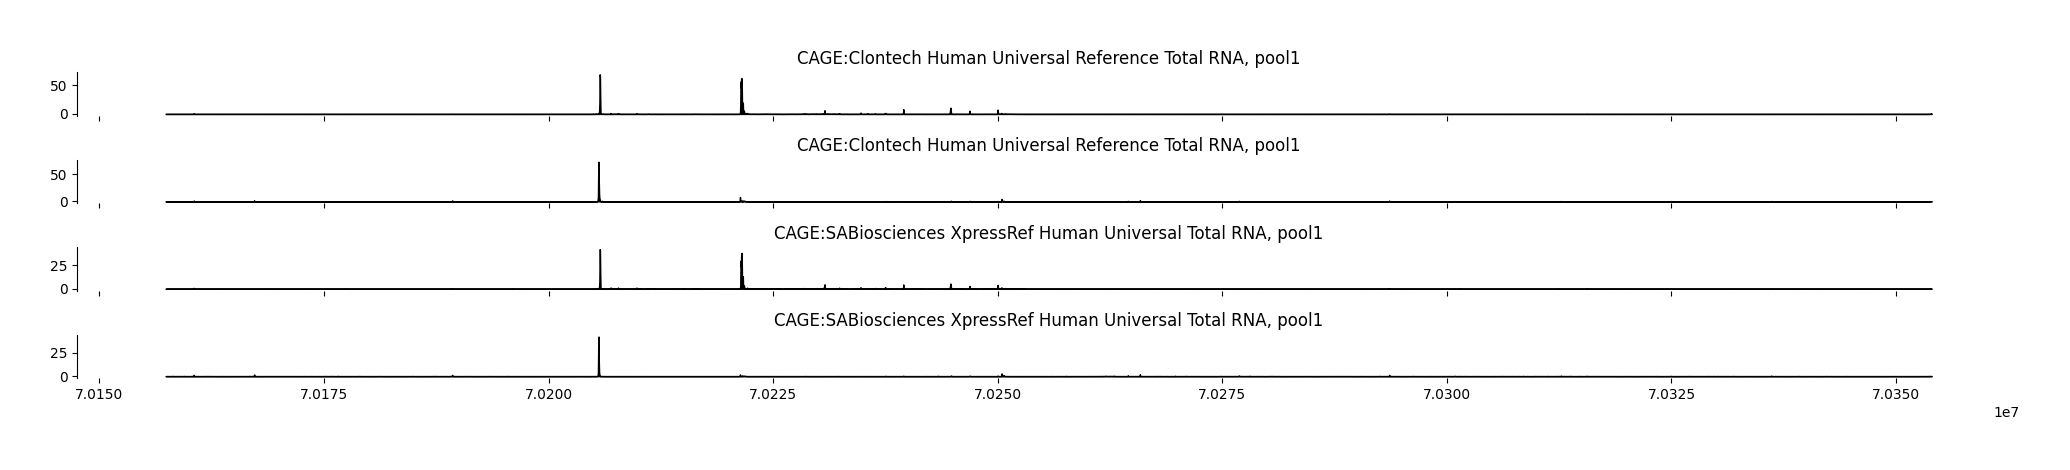

In [14]:
tasks_to_plot = range(0, 4)
task_names = tasks.description[tasks_to_plot]

fig = grelu.visualize.plot_tracks(
    preds[0, tasks_to_plot, :],
    start_pos=output_start, # Start coordinate of the output
    end_pos=output_end, # End coordinate of the output
    titles=task_names, # Description of these tracks from the `tasks` dataframe
    figsize=(20, 4), # width, height
)

## Add genomic annotations

We can also extract genomic annotations and visualize them alongside the predicted activity. Note that we use genomepy and you may need to install some UCSC tools to access the annotations. If you do not have these installed, you can use the commands below, or skip this section.

In [ ]:
#rsync -aP rsync://hgdownload.soe.ucsc.edu/genome/admin/exe/linux.x86_64/genePredToBed /usr/bin/
#rsync -aP rsync://hgdownload.soe.ucsc.edu/genome/admin/exe/linux.x86_64/genePredToGtf /usr/bin/
#rsync -aP rsync://hgdownload.soe.ucsc.edu/genome/admin/exe/linux.x86_64/bedToGenePred /usr/bin/
#rsync -aP rsync://hgdownload.soe.ucsc.edu/genome/admin/exe/linux.x86_64/gtfToGenePred /usr/bin/
#rsync -aP rsync://hgdownload.soe.ucsc.edu/genome/admin/exe/linux.x86_64/gff3ToGenePred /usr/bin/

Below, we will extract the coordinates for exons in hg38:

In [15]:
import grelu.io.genome

exons = grelu.io.genome.read_gtf("hg38", features="exon")
exons.head(3)

22:25:03 | WARNING | Could not find 'hg38.annotation.bed(.gz)' in directory /root/.local/share/genomes/hg38. Methods using this file won't work!
22:25:03 | WARNING | Could not find 'hg38.annotation.gtf(.gz)' in directory /root/.local/share/genomes/hg38. Methods using this file won't work!
22:25:03 | INFO | Downloading the ncbiRefSeq annotation from the UCSC MySQL database.


Genome annotation files not found. Installing genome annotation files.


22:25:11 | INFO | Annotation download successful


,chrom,start,end,gene_name,source,feature,score,strand,frame,attribute
1,chr1,11874,12227,DDX11L1,genomepy,exon,.,+,.,"gene_id ""DDX11L1""; transcript_id ""NR_046018.2""..."
2,chr1,12613,12721,DDX11L1,genomepy,exon,.,+,.,"gene_id ""DDX11L1""; transcript_id ""NR_046018.2""..."
3,chr1,13221,14409,DDX11L1,genomepy,exon,.,+,.,"gene_id ""DDX11L1""; transcript_id ""NR_046018.2""..."


We filter those exons that are completely contained within the region we are predicting:

In [16]:
import grelu.data.preprocess

exons = grelu.data.preprocess.filter_overlapping(
    exons,
    ref_intervals=output_intervals,
    method="all"
)
exons.head(3)

Keeping 560 intervals


,chrom,start,end,gene_name,source,feature,score,strand,frame,attribute
176828,chr1,70159330,70159438,LRRC40,genomepy,exon,.,-,.,"gene_id ""LRRC40""; transcript_id ""XM_047424520...."
176830,chr1,70173465,70173510,LRRC40,genomepy,exon,.,-,.,"gene_id ""LRRC40""; transcript_id ""XM_047424520...."
176832,chr1,70173622,70173709,LRRC40,genomepy,exon,.,-,.,"gene_id ""LRRC40""; transcript_id ""XM_047424520...."


This gives us all the exon coordinates in the output region. We also want to annotate each gene, so let's create a genes dataframe spanning the first to the last exon of each gene:

In [17]:
genes = exons[['gene_name', 'chrom', 'strand']].drop_duplicates()
genes = genes.merge(exons.groupby("gene_name").start.min().reset_index())
genes = genes.merge(exons.groupby("gene_name").end.max().reset_index())
genes = genes.rename(columns={"gene_name": "label"})
genes

,label,chrom,strand,start,end
0,LRRC40,chr1,-,70159330,70205579
1,SRSF11,chr1,+,70205696,70253052
2,ANKRD13C,chr1,-,70258999,70336099


## Plot predictions with annotations

Now, we can add these annotations to the plot.

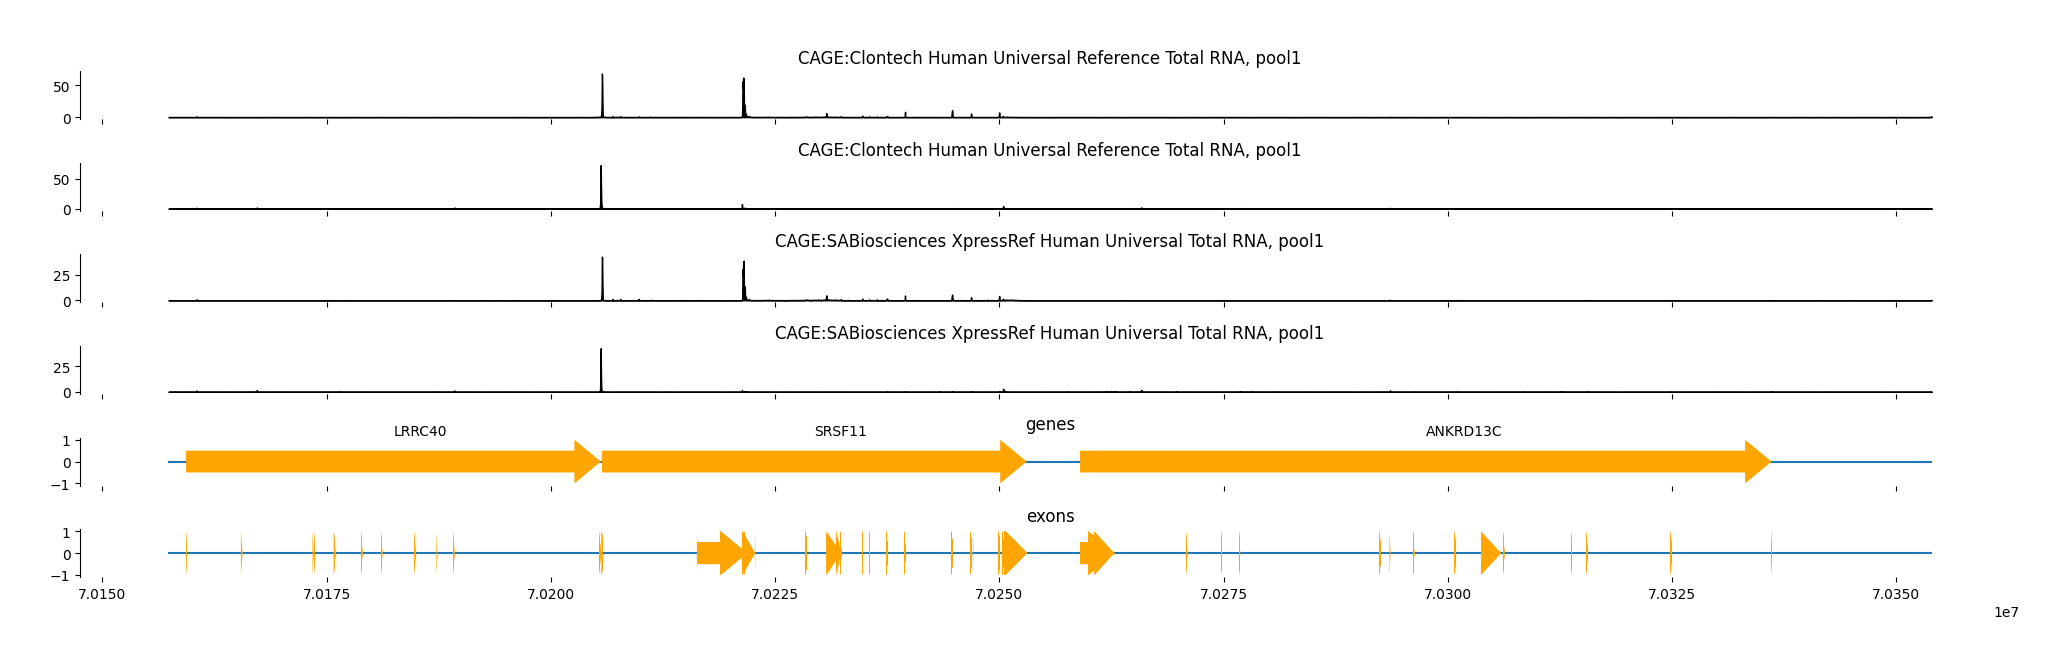

In [18]:
fig = grelu.visualize.plot_tracks(
    preds[0, tasks_to_plot, :],
    start_pos=output_start,
    end_pos=output_end,
    titles=task_names,
    figsize=(20, 6),
    annotations={"genes":genes, "exons":exons}
)

## Analyze attention weights

Borzoi contains several transformer layers. Here, we can analyze the attention weights to see the relationships between local sequence regions. We use the `grelu.interpret.score` module which contains functions to score the importance of input bases.

In [21]:
import grelu.interpret.score

attn = grelu.interpret.score.get_attention_scores(
    model=model,
    seqs=input_seq, # You can also supply just the genomic interval
    genome='hg38',
    block_idx=-1, # We take attention weights from the final transformer layer
)

attn.shape

(8, 4096, 4096)

Note the shape: It is in the form `heads, bins, bins`. The first dimension is of length 8 since the transformer layer contains 8 heads. We will average the weights of all heads together and visualize them:

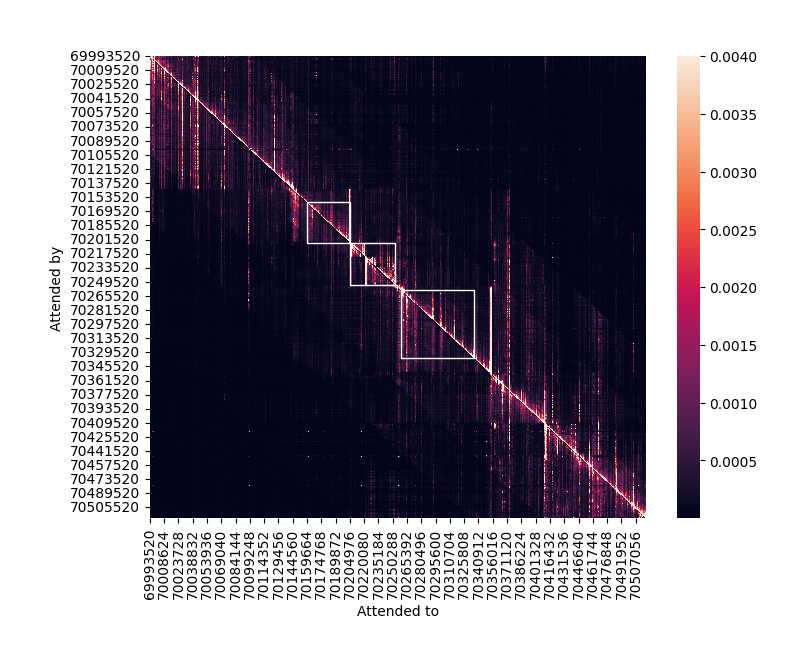

In [20]:
attn = attn.mean(0)

fig = grelu.visualize.plot_attention_matrix(
    attn,
    start_pos=input_start,
    end_pos=input_end,
    highlight_intervals=genes, # Draw a box around each gene
    vmax=0.004,
    figsize=(8, 6)
)

## Calculate tissue specific expression over SRSF11 exons

Suppose we are interested in a specific function of the output - the total RNA-seq expression over all exons of the SRSF11 gene. Further, we are interested in the tissue specificity of this expression, in brain vs. liver. We first identify the relevant tasks in the model's predictions.

In [22]:
brain_tasks = tasks[(tasks.assay == "RNA") & (tasks["sample"].str.contains("brain"))].index.tolist()
print(brain_tasks)

[6635, 6636, 7539, 7540, 7541]


In [23]:
liver_tasks = tasks[(tasks.assay == "RNA") & (tasks["sample"].str.contains("liver"))].index.tolist()
print(liver_tasks)

[6132, 6133, 6146, 6147, 6437, 6438, 6490, 6491, 6579, 6580, 6582, 6583, 6691, 6692, 6730, 6731, 6770, 6916, 6917, 7181, 7182, 7563, 7564, 7565]


Let's look at what these tasks are:

In [24]:
tasks.iloc[brain_tasks].head()

,name,file,clip,clip_soft,scale,sum_stat,strand_pair,description,assay,sample
6635,ENCFF637ZBG+,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.30,sum_sqrt,6636,RNA:brain tissue female adult (66 years),RNA,brain tissue female adult (66 years)
6636,ENCFF637ZBG-,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.30,sum_sqrt,6635,RNA:brain tissue female adult (66 years),RNA,brain tissue female adult (66 years)
7539,GTEX-13FTY-0011-R11a-SM-5IJEA.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.01,sum_sqrt,7539,RNA:brain,RNA,brain
7540,GTEX-1EX96-0011-R4a-SM-ARU82.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.01,sum_sqrt,7540,RNA:brain,RNA,brain
7541,GTEX-1H3O1-1726-SM-9WYSR.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.01,sum_sqrt,7541,RNA:brain,RNA,brain


In [25]:
tasks.iloc[liver_tasks].head()

,name,file,clip,clip_soft,scale,sum_stat,strand_pair,description,assay,sample
6132,ENCFF945UHI+,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.3,sum_sqrt,6133,RNA:liver tissue female child (6 years) and wi...,RNA,liver tissue female child (6 years) and with n...
6133,ENCFF945UHI-,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.3,sum_sqrt,6132,RNA:liver tissue female child (6 years) and wi...,RNA,liver tissue female child (6 years) and with n...
6146,ENCFF630VID+,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.3,sum_sqrt,6147,RNA:liver tissue female embryo (20 weeks) and ...,RNA,liver tissue female embryo (20 weeks) and male...
6147,ENCFF630VID-,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.3,sum_sqrt,6146,RNA:liver tissue female embryo (20 weeks) and ...,RNA,liver tissue female embryo (20 weeks) and male...
6437,ENCFF521SQI+,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.3,sum_sqrt,6438,RNA:liver tissue male adult (18 years),RNA,liver tissue male adult (18 years)


We also need to identify the relevant output bins that overlap with exons of SRSF11.

In [26]:
srsf11_exons = exons[exons.gene_name == "SRSF11"]
srsf11_exons.head()

,chrom,start,end,gene_name,source,feature,score,strand,frame,attribute
176928,chr1,70205696,70205780,SRSF11,genomepy,exon,.,+,.,"gene_id ""SRSF11""; transcript_id ""XM_047434541...."
176929,chr1,70216294,70221839,SRSF11,genomepy,exon,.,+,.,"gene_id ""SRSF11""; transcript_id ""XM_047434541...."
176931,chr1,70228422,70228555,SRSF11,genomepy,exon,.,+,.,"gene_id ""SRSF11""; transcript_id ""XM_047434541...."
176933,chr1,70232268,70232377,SRSF11,genomepy,exon,.,+,.,"gene_id ""SRSF11""; transcript_id ""XM_047434541...."
176935,chr1,70234696,70234788,SRSF11,genomepy,exon,.,+,.,"gene_id ""SRSF11""; transcript_id ""XM_047434541...."


We have another coordinate-conversion function for this:

In [27]:
srsf11_exons = model.input_intervals_to_output_bins(
    intervals=srsf11_exons,
    start_pos=input_start
)
srsf11_exons.head(3)

,chrom,start,end,gene_name,source,feature,score,strand,frame,attribute,bin_start,bin_end
176928,chr1,70205696,70205780,SRSF11,genomepy,exon,.,+,.,"gene_id ""SRSF11""; transcript_id ""XM_047434541....",1510,1514
176929,chr1,70216294,70221839,SRSF11,genomepy,exon,.,+,.,"gene_id ""SRSF11""; transcript_id ""XM_047434541....",1841,2015
176931,chr1,70228422,70228555,SRSF11,genomepy,exon,.,+,.,"gene_id ""SRSF11""; transcript_id ""XM_047434541....",2220,2225


We now have the indices of all the bins that overlap with each exon! Let's combine them:

In [28]:
selected_bins = set()
for row in srsf11_exons.itertuples():
    selected_bins = selected_bins.union(list(range(row.bin_start, row.bin_end)))

selected_bins = list(selected_bins)

print(len(selected_bins))

379


Thus, out of the 6144 bins in the model's output, we are interested in only a subset of them. Now, we can use the `grelu.transforms` module to define a transform or objective function that calculates a specific score from the model's predictions. We use the `Specificity` transform since we are computing the difference between on- and off- target tasks. To simply compute the mean or total prediction over specific regions/tasks, use the `Aggregate` transform.

In [29]:
import grelu.transforms.prediction_transforms

brain_specific_srsf11_score = grelu.transforms.prediction_transforms.Specificity(
    on_tasks = brain_tasks, # positive tasks
    off_tasks = liver_tasks, # negative tasks
    positions = selected_bins, # The relevant regions of the output
    on_aggfunc = "mean", # Average expression over the positive tasks
    off_aggfunc = "mean", # Average expression over the negative tasks
    length_aggfunc = "mean", # Average expression over the bins
    compare_func = "divide", # Return the ratio of expression in positive tasks to negative tasks
)

By applying this function to our model's predictions, we get the ratio between the mean expression in exons of SRSF11 in brain RNA-seq tracks vs. in liver RNA-seq tracks.

In [30]:
brain_specific_srsf11_score.compute(preds)

array([[[1.6093167]]], dtype=float32)

Thus, the total expression over all annotated SRSF11 exons is on average 1.6x higher in brain RNA-seq tracks.

## ISM with respect to specific expression

We can perform In Silico Mutagenesis (ISM) to identify which bases in the input sequence are contributing to the tissue-specific expression. Since ISM on all 524288 bases would take a long time, we will take 100 bases upstream and downstream of the start position of the first exon.

In [31]:
ism_start_pos = srsf11_exons.start.min() - 100
ism_end_pos = srsf11_exons.start.min() + 100
print(ism_start_pos, ism_end_pos)

70205596 70205796


In [32]:
%%time

ism = grelu.interpret.score.ISM_predict(
    seqs=input_seq, # You can also supply genomic intervals
    model=model,
    genome="hg38",
    prediction_transform=brain_specific_srsf11_score, # We will compute how each base affects this score
    devices=1, # Index of the GPU to use
    batch_size=8,
    num_workers=1,
    start_pos=ism_start_pos-input_start, # Relative start position from the first base
    end_pos=ism_end_pos-input_start, # Relative end position from the first base
    return_df=True, # Return a dataframe
    compare_func="log2FC", # Return the log2 ratio between the predictions for the mutated sequence and the reference sequence
)

ism.shape

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]
CPU times: user 1min 36s, sys: 1.81 s, total: 1min 38s
Wall time: 1min 39s


(4, 200)

The output here is a dataframe with 4 rows corresponding to the bases that were substituted at each position (A, C, G and T) and 200 columns, one for each position that was mutated. Because we selected `compare_func="log2FC"`, the values in the dataframe represent log (score of mutated sequence / score of original sequence).

In [33]:
ism.iloc[:, :10]

,C,C,G,T,T,G,G,G,A,T
A,-0.000299,-0.001693,-8.183535e-04,-2.084645e-03,-1.101711e-03,-6.554027e-04,6.044548e-03,-3.341879e-03,-8.599132e-08,4.213778e-03
C,0.000000,0.000000,-2.890224e-03,-2.396418e-03,1.423946e-04,1.818258e-03,3.637487e-03,-3.093585e-03,2.121050e-03,3.584649e-03
G,-0.004889,-0.004769,1.719826e-07,-2.272992e-03,-2.596866e-03,1.719826e-07,1.719826e-07,1.719826e-07,-6.701140e-04,-2.185921e-03
T,0.000050,0.000599,-4.778532e-03,-8.599132e-08,-8.599132e-08,-1.613669e-03,1.631536e-03,1.034620e-03,3.456319e-03,-8.599132e-08


We can visualize these ISM scores in two ways: as a heatmap or as a sequence logo where the height of each base corresponds to its importance.

<Axes: >

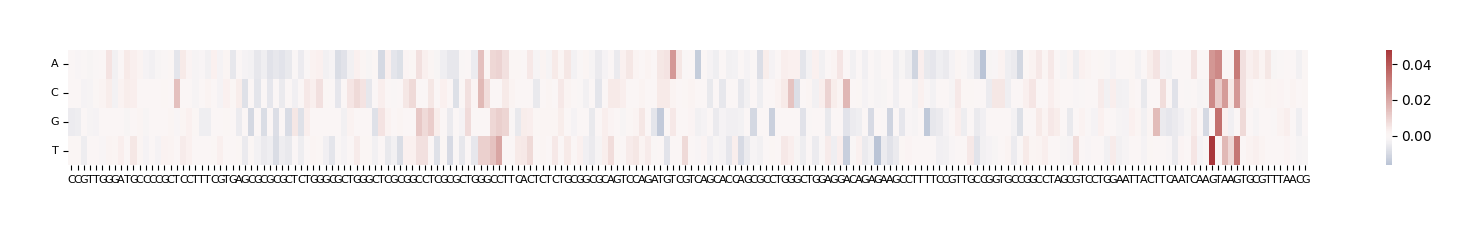

In [34]:
grelu.visualize.plot_ISM(ism, method="heatmap", figsize=(20, 1.5), center=0)

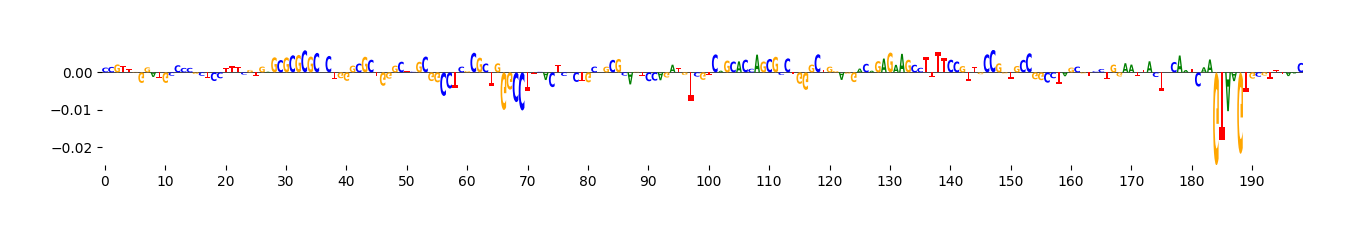

In [35]:
grelu.visualize.plot_ISM(ism, method="logo", figsize=(15.5, 1.5))

See the subsequent tutorials to learn about other things you can do with this model, including fine-tuning, variant effect prediction, and sequence design.